# Data analyse CLT

#### Packages

In [9]:
#Import packages
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import tarfile
import io
import csv
import pandas as pd
# import netCDF4
# import h5netcdf
# import glob

#### Functions

In [10]:
#Function to read (csv) data file
def read_data(filename):
    headers = ['lon','lat','type','r','z']
    df = pd.read_csv(filename,skiprows=1,names= headers,delim_whitespace=True)
    return df

In [11]:
#Function to read (nc) data file
def nc_read(directory):
    data = xr.open_mfdataset(directory)
    return data

In [12]:
#Read data from the coordinates of the wind turbines
turbines = read_data('E:\data\wind_turbine_coordinates_2020_2050.tab')

In [13]:
#Importing the mask of wind turbines 900 and 901
directory_mask = "C:/Users/esmer/OneDrive/TN jaar 3/BEP/mask_type900901.nc"
mask_type900901 = nc_read(directory_mask)

In [14]:
#Importing the mask of wind turbines in the sea
directory_mask = "C:/Users/esmer/OneDrive/TN jaar 3/BEP/masksea.nc"
mask_sea = nc_read(directory_mask)

#### Determine the different seasons: spring, summer, autumn, winter

In [15]:
#The directories for the different seasons
#Spring, summer, autumn, winter
directory1 = ["E:/data/transfer_1722109_files_fe942ebb/CLT - kopie/CLTlente/clt.his.GERMAN_BIGHT.WINS50_43h21_fERA5_WFP_2050_ptA.2020*.1hr.nc",
             "E:/data/transfer_1722109_files_fe942ebb/CLT - kopie/CLTzomer/clt.his.GERMAN_BIGHT.WINS50_43h21_fERA5_WFP_2050_ptA.2020*.1hr.nc",
             "E:/data/transfer_1722109_files_fe942ebb/CLT - kopie/CLTHerfst/clt.his.GERMAN_BIGHT.WINS50_43h21_fERA5_WFP_2050_ptA.2020*.1hr.nc",
             "E:/data/transfer_1722109_files_fe942ebb/CLT - kopie/CLTwinter/clt.his.GERMAN_BIGHT.WINS50_43h21_fERA5_WFP_2050_ptA.2020*.1hr.nc"]

directory2 = ["E:/data/transfer_1722109_files_fe942ebb/CLT - kopie/CLTlenteCTL/clt.his.GERMAN_BIGHT.WINS50_43h21_fERA5_CTL_ptA.2020*.1hr.nc",
             "E:/data/transfer_1722109_files_fe942ebb/CLT - kopie/CLTzomerCTL/clt.his.GERMAN_BIGHT.WINS50_43h21_fERA5_CTL_ptA.2020*.1hr.nc",
             "E:/data/transfer_1722109_files_fe942ebb/CLT - kopie/CLTherfstCTL/clt.his.GERMAN_BIGHT.WINS50_43h21_fERA5_CTL_ptA.2020*.1hr.nc",
             "E:/data/transfer_1722109_files_fe942ebb/CLT - kopie/CLTWinterCTL/clt.his.GERMAN_BIGHT.WINS50_43h21_fERA5_CTL_ptA.2020*.1hr.nc"]

# Qualitative approach

## Difference in CLT

#### Determine the minimum and maximum of difference in CLT to determine the boundaries of the colorbar

In [16]:
min = []
max = []
for i in range(4):    
    CLTwfp = nc_read(directory1[i])
    CLTctl = nc_read(directory2[i])
    avgCLTwfp = CLTwfp.mean(dim='time')
    avgCLTctl = CLTctl.mean(dim='time')
    diffCLT = avgCLTwfp - avgCLTctl
    minimum = np.min(diffCLT.clt.values)
    maximum = np.max(diffCLT.clt.values)
    min = np.append(min,minimum)
    max = np.append(max,maximum)
    
print(min)
print(max)

[-0.02811712 -0.04283321 -0.02482432 -0.02231884]
[0.03260887 0.04214054 0.0381614  0.03095788]


#### Plotting the difference in CLT between CTL and WFP

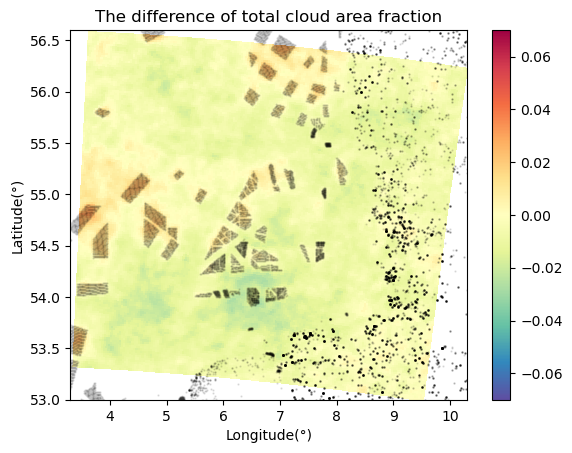

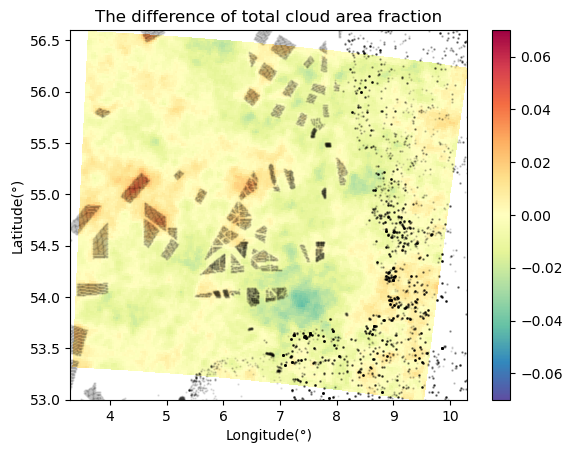

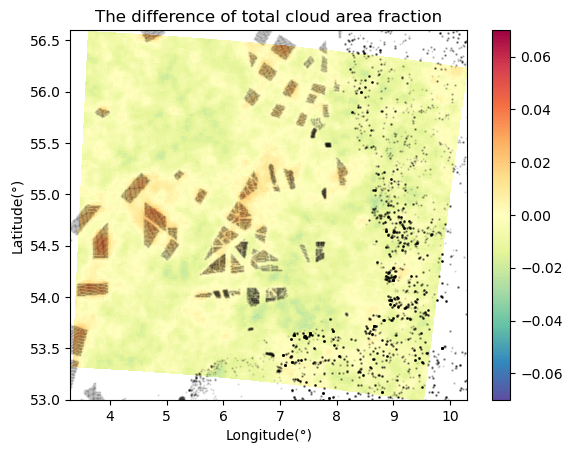

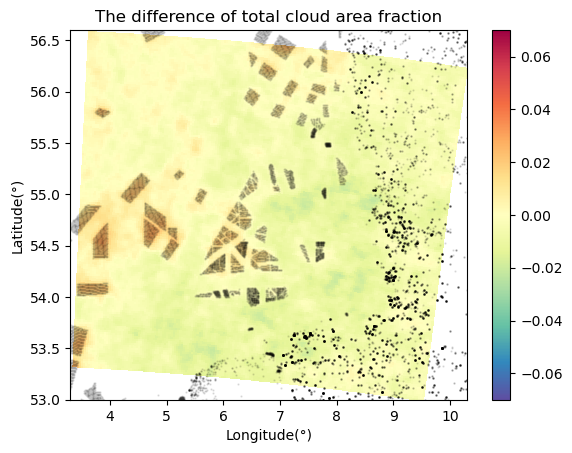

In [17]:
#For loop to plot the difference in CLT with and without wind farms
#plt.figure(dpi=1200)
for i in range(4):
    CLTwfp = nc_read(directory1[i])
    CLTctl = nc_read(directory2[i])
    avgCLTwfp = CLTwfp.mean(dim='time')
    avgCLTctl = CLTctl.mean(dim='time')
    diffCLT = avgCLTwfp - avgCLTctl
    plt.pcolormesh(diffCLT.lon,diffCLT.lat,diffCLT.clt,cmap='Spectral_r',vmin=-0.07,vmax=0.07)
    plt.colorbar()
    plt.scatter(turbines.lon,turbines.lat,s=0.5,c='k',alpha=0.1)
    plt.xlabel('Longitude(°)')
    plt.ylabel('Latitude(°)')
    plt.title('The difference of total cloud area fraction')
    plt.xlim(3.3,10.3)
    plt.ylim(53,56.6)
#     plt.savefig('CLL.jpg',dpi=300) #save the figure
    plt.show()

# Quantitative approach

## Using mask for calculating difference in CLT

#### Kwantitatief verschil bepalen in CLT voor een windmolen van type 900 en 901

In [18]:
#Opening the mask, since the mask is saved in a netCDF file
#Importing the mask of wind turbines 900 and 901
directory_mask = "C:/Users/esmer/OneDrive/TN jaar 3/BEP/mask_type900901.nc"
mask_type900901 = nc_read(directory_mask)

In [20]:
#We gaan voor 4 verschillende seizoenen bepalen wat het gemiddelde verschil in CLT is tussen CTL en WFP
CLT = []
for i in range(4): 
    CLTwfp = nc_read(directory1[i])
    CLTctl = nc_read(directory2[i])
    avgCLTwfp = CLTwfp.mean(dim="time")
    avgCLTctl = CLTctl.mean(dim="time")
    diffCLT = avgCLTwfp - avgCLTctl
    diff = diffCLT.clt.values*mask_type900901.__xarray_dataarray_variable__.values
    sumCLT = np.sum(diff)
    sumturbines = np.sum(mask_type900901.__xarray_dataarray_variable__.values)
    avgdiffCLT = sumCLT/sumturbines
    CLT = np.append(CLT,avgdiffCLT)    
print(CLT)

[0.00804021 0.00889141 0.01242895 0.01054389]


## Calculating total difference in CLT 

In [24]:
CLTavg=[]
for i in range(4):
    CLTwfp = nc_read(directory1[i])
    CLTctl = nc_read(directory2[i])
    avgCLTwfp = CLTwfp.mean(dim='time')
    avgCLTctl = CLTctl.mean(dim='time')
    diffCLT = avgCLTwfp - avgCLTctl
    sumclt = np.sum(diffCLT.clt.values) #Sum of the low cloud area fraction between wfp and ctl
    gridpoints = np.ones([146,166]) #The amount of grid points
    sumgridpoints = np.sum(gridpoints)
    avgclt = sumclt/sumgridpoints
    CLTavg=np.append(CLTavg,avgclt)
    
print(CLTavg)

[-0.00619558 -0.00348165 -0.00516162 -0.00402061]


In [25]:
np.mean(CLTavg)

-0.0047148653217069505

In [23]:
CLTsea = []
for i in range(4): 
    CLTwfp = nc_read(directory1[i])
    CLTctl = nc_read(directory2[i])
    avgCLTwfp = CLTwfp.mean(dim="time")
    avgCLTctl = CLTctl.mean(dim="time")
    diffCLT = avgCLTwfp - avgCLTctl
    diff = diffCLT.clt.values*mask_sea.__xarray_dataarray_variable__.values
    sumCLT = np.sum(diff)
    sumturbines = np.sum(mask_sea.__xarray_dataarray_variable__.values)
    avgdiffCLT = sumCLT/sumturbines
    CLT = np.append(CLT,avgdiffCLT)    
print(CLT)

[0.00804021 0.00889141 0.01242895 0.01054389 0.00575253 0.00710271
 0.01065294 0.00874087]
